In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate the Stress-Strain Curves using Return Mapping Algorithm (for both training and test datasets)

def generate_stress_strain_curve(strain_history, material_constants):
    """
    Generate stress-strain data using the return mapping algorithm.
    """
    stress_history = []
    eps_p = 0
    sigma_k1, sigma_k2, sigma_k3, sigma_i = 0, 0, 0, 0  # Initialize back stresses and isotropic hardening
    
    for strain in strain_history:
        E, sigma_y, c, gamma, b, Q = material_constants
        sigma_trial, yield_function = elastic_predictor(strain, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)
        
        # Run return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )
        stress_history.append(sigma_updated)
    
    return stress_history

# Step 2: Train the Neural Network (Already completed in your provided code)

# Assuming the neural network is already trained and ready to use.

# Step 3: Predict Stress using Neural Network
def predict_stress_using_nn(strain_history, material_constants, model, scaler_X, scaler_y):
    """
    Use the trained neural network model to predict stress-strain data.
    """
    stress_history_nn = []
    
    for strain in strain_history:
        E, sigma_y, c, gamma, b, Q = material_constants
        trial_phi = np.abs(E * strain) - sigma_y  # Simplified trial phi
        
        # Prepare input for the neural network
        X_input = np.array([E, sigma_y, c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, trial_phi]).reshape(1, -1)
        X_input_normalized = scaler_X.transform(X_input)  # Normalize input
        
        # Predict plastic strain increment using neural network
        plastic_strain_pred = model.predict(X_input_normalized)
        plastic_strain_pred_denormalized = scaler_y.inverse_transform(plastic_strain_pred)  # Denormalize prediction
        
        # Calculate stress using predicted plastic strain
        stress_nn = E * (strain - plastic_strain_pred_denormalized)
        stress_history_nn.append(stress_nn[0][0])
    
    return stress_history_nn

# Step 4: Generate Training and Test Curves (Return Mapping and Neural Network)

# Generate training stress-strain curves using the return mapping algorithm
strain_history_training = generate_strain_history(1500, 0.0001, 0.0002)  # Adjust bounds as per the training data
material_constants_training = training[0, :-2]  # Use material constants from the training dataset
stress_history_training_return_mapping = generate_stress_strain_curve(strain_history_training, material_constants_training)

# Predict training stress-strain using the neural network
stress_history_training_nn = predict_stress_using_nn(strain_history_training, material_constants_training, model, scaler_X, scaler_y)

# Generate test stress-strain curves using the return mapping algorithm
strain_history_test = generate_strain_history(1500, 0.0002, 0.0004)  # Use bounds for test dataset
material_constants_test = test2[0, :-2]  # Use material constants from the test dataset
stress_history_test_return_mapping = generate_stress_strain_curve(strain_history_test, material_constants_test)

# Predict test stress-strain using the neural network
stress_history_test_nn = predict_stress_using_nn(strain_history_test, material_constants_test, model, scaler_X, scaler_y)

# Step 5: Plot the Results (Return Mapping vs Neural Network)

plt.figure(figsize=(10, 6))

# Plot for training dataset
plt.plot(strain_history_training, stress_history_training_return_mapping, label="Return Mapping - Training", linestyle='--', color='blue')
plt.plot(strain_history_training, stress_history_training_nn, label="NN Model - Training", color='blue')

# Plot for test dataset
plt.plot(strain_history_test, stress_history_test_return_mapping, label="Return Mapping - Test", linestyle='--', color='red')
plt.plot(strain_history_test, stress_history_test_nn, label="NN Model - Test", color='red')

# Add labels and legend
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Stress-Strain Curves: Return Mapping vs Neural Network')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define material constants range (Table 1 in paper)
E_range = [60e9, 210e9]  # MPa
sigma_y_range = [90e6, 1000e6]  # MPa
c_range = [1e6, 250e9]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1e6, 150e6]  # MPa

# Generate Latin Hypercube Samples for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))

# Generate cyclic strain increments (following strain history in Fig. 4)
def generate_strain_history(num_samples, amplitude):
    strain_history = np.zeros(num_samples)
    for i in range(num_samples):
        strain_history[i] = amplitude * np.sin(2 * np.pi * i / num_samples)
    return strain_history

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated
        
        delta_gamma = newton(plastic_residual, 1e-5)  # Solve for plastic multiplier

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate stress-strain curve using return mapping algorithm
def generate_stress_strain_curve(material_constants, strain_history):
    stress_history = []
    eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = 0, 0, 0, 0, 0
    for strain in strain_history:
        E, sigma_y, c, gamma, b, Q = material_constants
        sigma_trial, yield_function = elastic_predictor(strain, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i,
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )
        stress_history.append(sigma_updated)
    return np.array(stress_history)

# Generate dataset for stress-strain comparison (Fig. 8)
def generate_stress_strain_data():
    # Generate material constants
    material_constants = generate_material_constants_lhs(1)[0]  # Single material set

    # Generate strain history (same as in Fig. 4 for training and test datasets)
    strain_history_train = generate_strain_history(1500, amplitude=0.045)
    strain_history_test1 = generate_strain_history(1500, amplitude=0.015)
    strain_history_test2 = generate_strain_history(1500, amplitude=0.09)

    # Generate stress-strain data using return mapping
    stress_train = generate_stress_strain_curve(material_constants, strain_history_train)
    stress_test1 = generate_stress_strain_curve(material_constants, strain_history_test1)
    stress_test2 = generate_stress_strain_curve(material_constants, strain_history_test2)

    # Plotting the stress-strain curves
    plt.figure(figsize=(8, 6))
    plt.plot(strain_history_train, stress_train, label="Training Data (0.045 amplitude)", linestyle='--')
    plt.plot(strain_history_test1, stress_test1, label="Test Data 1 (0.015 amplitude)", linestyle=':')
    plt.plot(strain_history_test2, stress_test2, label="Test Data 2 (0.09 amplitude)", linestyle='-')
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.title("Stress-Strain Curves (Return Mapping Algorithm)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
generate_stress_strain_data()


2024-10-01 11:06:39.728275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 11:06:39.728943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 11:06:39.731211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-01 11:06:39.738024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 11:06:39.749382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

ValueError: too many values to unpack (expected 6)

In [25]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define the range for material constants as per Table 1 in the paper
E_range = [60e9, 210e9]  # MPa
sigma_y_range = [90e6, 1000e6]  # MPa
c_range = [1e6, 250e9]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1e6, 150e6]  # MPa


# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 500
NΔε = 1500

# Generate Latin Hypercube Sample for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))

# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain
    
    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.linspace(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.linspace(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain
    
    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.linspace(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    return strain_history

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated
        
        delta_gamma = newton(plastic_residual, 1e-5)  # Solve for plastic multiplier

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate dataset
def generate_dataset(lb,ub, num_material_samples=500, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples,lb,ub)
    
    # Create Cartesian product: for each material constant set, apply all strain increments
    repeated_material_constants = np.repeat(material_constants, len(strain_history) // num_material_samples, axis=0)
    repeated_strain_history = np.tile(strain_history, num_material_samples)
    dataset = []
    
    for i in range(len(repeated_material_constants)):
        E, sigma_y, c, gamma, b, Q = repeated_material_constants[i, 0], repeated_material_constants[i, 1], \
                                     repeated_material_constants[i, 2:5], repeated_material_constants[i, 5:8], \
                                     repeated_material_constants[i, 8], repeated_material_constants[i, 9]
        strain_inc = repeated_strain_history[i]
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0  # Initialize back stress and plastic strain

        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(strain_inc, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Run the return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain_inc, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )

        # Calculate trial phi (trialϕ)
        trial_phi = np.abs(sigma_trial) - sigma_y  
        dataset.append(np.hstack([repeated_material_constants[i], trial_phi, eps_p]))
    
    dataset = np.array(dataset)
    return dataset


In [26]:
# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('loss_curve')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebook
    print(f"Plot saved as {'loss_curve'}")

# Plot original vs predicted values
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [27]:

# Example usage
training = generate_dataset(lb=0.0001,ub=0.0002)
save_dataset_to_csv(training)
test1 = generate_dataset(lb=0,ub=0.0001)
test2 = generate_dataset(lb=0.0002,ub=0.0004)

# Plot the plastic strain
columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
df = pd.DataFrame(training, columns=columns)
df1 = pd.DataFrame(test1, columns=columns)
df2 = pd.DataFrame(test2, columns=columns)
df['plastic_strain'].plot()
df1['plastic_strain'].plot()
df2['plastic_strain'].plot()
plt.legend(["Taining", "Test1",'Test2']);
# Add axis labels
plt.xlabel("Index")  # Label for x-axis
plt.ylabel("Plastic Strain")  # Label for y-axis

plt.show()
plt.savefig('dataset') 


ValueError: setting an array element with a sequence.

In [46]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define the range for material constants as per Table 1 in the paper
E_range = [60e9, 210e9]  # MPa
sigma_y_range = [90e6, 1000e6]  # MPa
c_range = [1e6, 250e9]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1e6, 150e6]  # MPa


# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 500
NΔε = 1500

# Generate Latin Hypercube Sample for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))


def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Linearly increasing positive strain
    for i in range(300):
        increment = np.linspace(lb, ub, 300)[i]  # Use linear increments
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Linearly decreasing negative strain
    for i in range(300, 900):
        increment = np.linspace(ub, lb, 600)[i - 300]  # Use linear decreasing increments
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Linearly increasing positive strain again
    for i in range(900, num_samples):
        increment = np.linspace(lb, ub, 600)[i - 900]  # Return to linear increments
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated
        
        delta_gamma = newton(plastic_residual, 1e-5)  # Solve for plastic multiplier

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Updated dataset generation using smooth strain history
def generate_dataset_with_smooth_strain(lb, ub, num_material_samples=500, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples,lb,ub)
    
    repeated_material_constants = np.repeat(material_constants, len(strain_history) // num_material_samples, axis=0)
    repeated_strain_history = np.tile(strain_history, num_material_samples)
    dataset = []
    
    for i in range(len(repeated_material_constants)):
        E, sigma_y, c, gamma, b, Q = repeated_material_constants[i, 0], repeated_material_constants[i, 1], \
                                     repeated_material_constants[i, 2:5], repeated_material_constants[i, 5:8], \
                                     repeated_material_constants[i, 8], repeated_material_constants[i, 9]
        strain_inc = repeated_strain_history[i]
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0  # Initialize back stress and plastic strain

        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(strain_inc, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Run the return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain_inc, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )

        trial_phi = np.abs(sigma_trial) - sigma_y  
        dataset.append(np.hstack([repeated_material_constants[i], trial_phi, eps_p]))
    
    dataset = np.array(dataset)
    return dataset



In [47]:
# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('loss_curve')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebook
    print(f"Plot saved as {'loss_curve'}")

# Plot original vs predicted values
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

Dataset saved to generated_dataset_training.csv


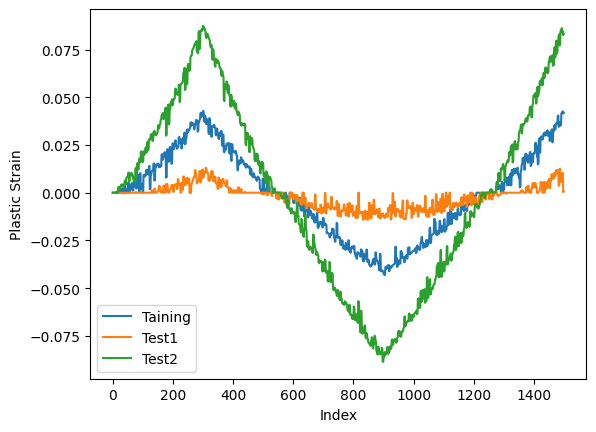

In [48]:

# Example usage
training = generate_dataset_with_smooth_strain(lb=0.0001,ub=0.0002)
save_dataset_to_csv(training)
test1 = generate_dataset_with_smooth_strain(lb=0,ub=0.0001)
test2 = generate_dataset_with_smooth_strain(lb=0.0002,ub=0.0004)

def moving_average(data, window_size=20):
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    # Padding to match the original length
    pad_size = len(data) - len(smoothed_data)
    padded_smoothed_data = np.pad(smoothed_data, (pad_size//2, pad_size - pad_size//2), mode='edge')
    return padded_smoothed_data



# Plot the plastic strain
columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
df = pd.DataFrame(training, columns=columns)
df1 = pd.DataFrame(test1, columns=columns)
df2 = pd.DataFrame(test2, columns=columns)
# Apply smoothing to the plastic strain values
df['plastic_strain_smoothed'] = moving_average(df['plastic_strain'].values, window_size=10)
df1['plastic_strain_smoothed'] = moving_average(df1['plastic_strain'].values, window_size=10)
df2['plastic_strain_smoothed'] = moving_average(df2['plastic_strain'].values, window_size=10)


df['plastic_strain'].plot()
df1['plastic_strain'].plot()
df2['plastic_strain'].plot()
plt.legend(["Taining", "Test1",'Test2']);
# Add axis labels
plt.xlabel("Index")  # Label for x-axis
plt.ylabel("Plastic Strain")  # Label for y-axis

plt.show()



In [49]:
plt.savefig('dataset.jpg') 

<Figure size 640x480 with 0 Axes>

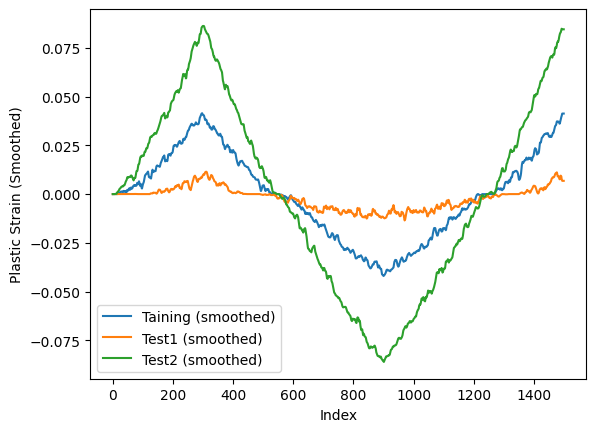

In [50]:

# Plot smoothed plastic strain
df['plastic_strain_smoothed'].plot()
df1['plastic_strain_smoothed'].plot()
df2['plastic_strain_smoothed'].plot()
plt.legend(["Taining (smoothed)", "Test1 (smoothed)", "Test2 (smoothed)"])
plt.xlabel("Index")  # Label for x-axis
plt.ylabel("Plastic Strain (Smoothed)")  # Label for y-axis
plt.show()

In [39]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

# Define the range for material constants as per Table 1 in the paper
E_range = [60e3, 210e3]  # MPa
sigma_y_range = [90, 1000]  # MPa
c_range = [1, 250e3]  # MPa
gamma_range = [0, 10000]
b_range = [1, 40]
Q_range = [1, 150]  # MPa


# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 500
NΔε = 1500

# Generate Latin Hypercube Sample for material constants
def generate_material_constants_lhs(num_samples):
    lhs_samples = lhs(10, samples=num_samples)
    E = lhs_samples[:, 0] * (E_range[1] - E_range[0]) + E_range[0]
    sigma_y = lhs_samples[:, 1] * (sigma_y_range[1] - sigma_y_range[0]) + sigma_y_range[0]
    c = lhs_samples[:, 2:5] * (c_range[1] - c_range[0]) + c_range[0]  # c1, c2, c3
    gamma = lhs_samples[:, 5:8] * (gamma_range[1] - gamma_range[0]) + gamma_range[0]  # gamma1, gamma2, gamma3
    b = lhs_samples[:, 8] * (b_range[1] - b_range[0]) + b_range[0]
    Q = lhs_samples[:, 9] * (Q_range[1] - Q_range[0]) + Q_range[0]
    return np.column_stack((E, sigma_y, c, gamma, b, Q))


# Generate strain history by accumulating linearly spaced increments
# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain
    
    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain
    
    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain
    
    return strain_history






# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated
        
        delta_gamma = newton(plastic_residual, 1e-5)  # Solve for plastic multiplier

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

# Generate dataset
def generate_dataset(lb,ub, num_material_samples=500, num_strain_samples=1500):
    material_constants = generate_material_constants_lhs(num_material_samples)
    strain_history = generate_strain_history(num_strain_samples,lb,ub)
    
    # Create Cartesian product: for each material constant set, apply all strain increments
    repeated_material_constants = np.repeat(material_constants, len(strain_history) // num_material_samples, axis=0)
    repeated_strain_history = np.tile(strain_history, num_material_samples)
    dataset = []
    
    for i in range(len(repeated_material_constants)):
        E, sigma_y, c, gamma, b, Q = repeated_material_constants[i, 0], repeated_material_constants[i, 1], \
                                     repeated_material_constants[i, 2:5], repeated_material_constants[i, 5:8], \
                                     repeated_material_constants[i, 8], repeated_material_constants[i, 9]
        strain_inc = repeated_strain_history[i]
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0  # Initialize back stress and plastic strain

        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(strain_inc, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Run the return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            strain_inc, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
        )

        # Calculate trial phi (trialϕ)
        trial_phi = np.abs(sigma_trial) - sigma_y  
        dataset.append(np.hstack([repeated_material_constants[i], trial_phi, eps_p]))
    
    dataset = np.array(dataset)
    return dataset



In [40]:
# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data), scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('loss_curve')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebook
    print(f"Plot saved as {'loss_curve'}")

# Plot original vs predicted values
def plot_predicted_vs_actual(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

Dataset saved to generated_dataset_training.csv


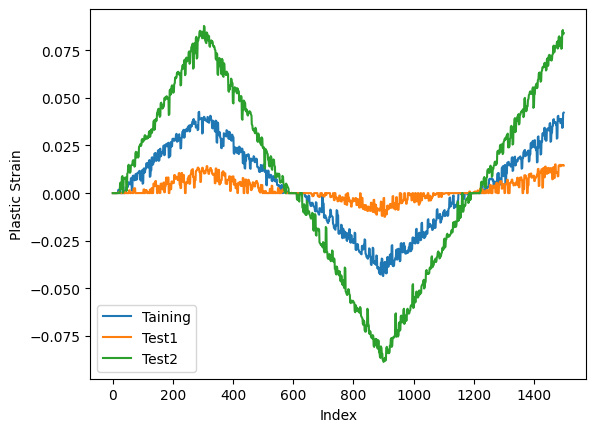

In [41]:

# Example usage
training = generate_dataset(lb=0.0001,ub=0.0002)
save_dataset_to_csv(training)
test1 = generate_dataset(lb=0,ub=0.0001)
test2 = generate_dataset(lb=0.0002,ub=0.0004)

# Plot the plastic strain
columns = ['E', 'sigma_y', 'c1', 'c2', 'c3', 'gamma1', 'gamma2', 'gamma3', 'b', 'Q', 'trial_phi', 'plastic_strain']
df = pd.DataFrame(training, columns=columns)
df1 = pd.DataFrame(test1, columns=columns)
df2 = pd.DataFrame(test2, columns=columns)
df['plastic_strain'].plot()
df1['plastic_strain'].plot()
df2['plastic_strain'].plot()
plt.legend(["Taining", "Test1",'Test2']);
# Add axis labels
plt.xlabel("Index")  # Label for x-axis
plt.ylabel("Plastic Strain")  # Label for y-axis

plt.show()



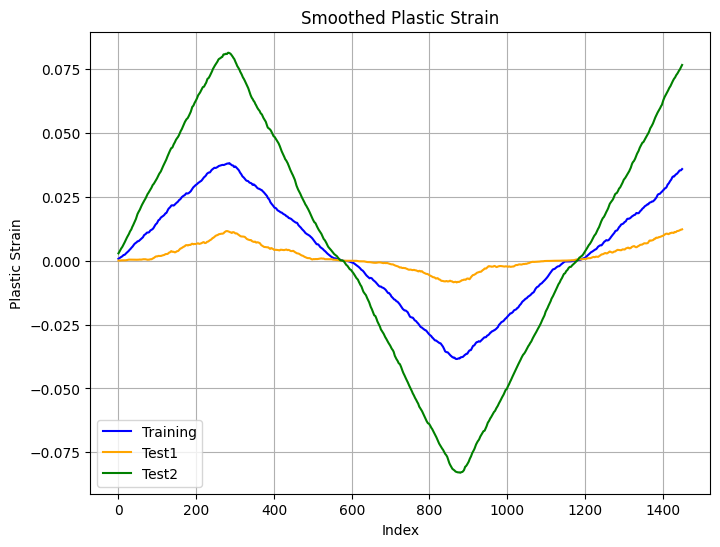

In [43]:
# Function to smooth the data using a moving average
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average to the generated data
smoothed_training = moving_average(df['plastic_strain'], window_size=50)
smoothed_test1 = moving_average(df1['plastic_strain'], window_size=50)
smoothed_test2 = moving_average(df2['plastic_strain'], window_size=50)

# Plot the smoothed plastic strain
plt.figure(figsize=(8, 6))
plt.plot(smoothed_training, label='Training', color='blue')
plt.plot(smoothed_test1, label='Test1', color='orange')
plt.plot(smoothed_test2, label='Test2', color='green')

# Add axis labels and title
plt.xlabel("Index")
plt.ylabel("Plastic Strain")
plt.title("Smoothed Plastic Strain")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
